Adapted from:
https://www.kaggle.com/paultimothymooney/identify-blood-cell-subtypes-from-images

An important problem in blood diagnostics is classifying different types of blood cells.  Here we have 410 original images and 12,500 augmented images of blood cells paired with subtype labels (Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil).  We want to automatically classify each image according to the subtype of cells within it.

For more information about blood cells and blood cell subtypes, see the following links:
https://www.ncbi.nlm.nih.gov/books/NBK2263/ and https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly

# Identify Blood Cell Subtypes From Images
* Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
* Mononuclear (Basophil + Lymphocyte vs Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

*Step One: Import Modules*

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

*Step Two: Plot Data*

In [2]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

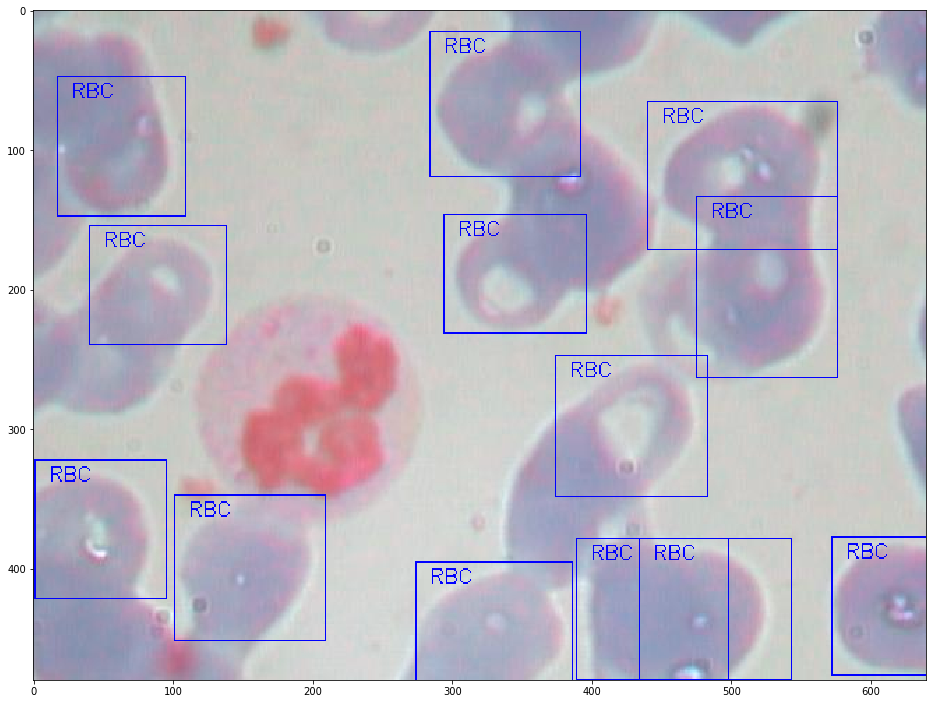

In [3]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("./dataset/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("./dataset/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

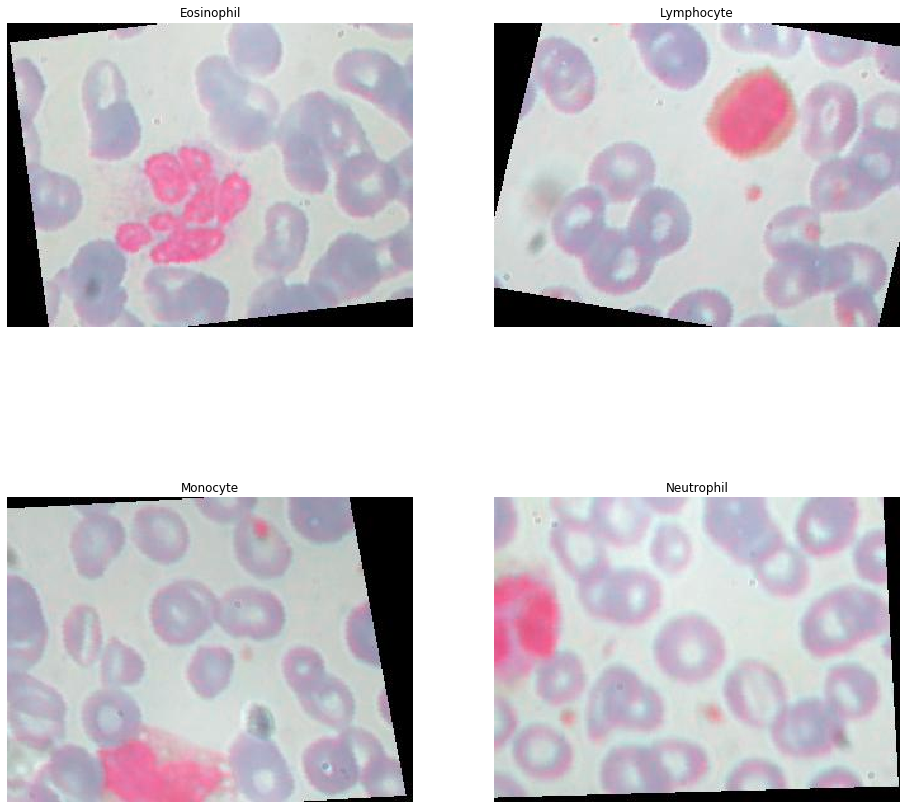

In [4]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = './dataset/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = './dataset/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = './dataset/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = './dataset/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

*Step Three: Describe Data*

In [5]:
reader = csv.reader(open('./dataset/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print('Basophil: ' + str(counts[0]) + '\n', 
      'Eosinophil: ' + str(counts[1]) + '\n', 
      'Lymphocyte: ' + str(counts[2]) + '\n',  
      'Monocyte: ' + str(counts[3]) + '\n', 
      'Neutrophil: ' + str(counts[4]) + '\n')

Basophil: 3
 Eosinophil: 88
 Lymphocyte: 33
 Monocyte: 21
 Neutrophil: 207



Here you can see that with the original images we have imbalanced class sizes.  We will use the augmented images instead because they no longer have imbalanced class sizes due to oversampling.

*Step Four: Load Augmented Dataset*

In [6]:
from tqdm import tqdm
from PIL import Image

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
                    img_file = cv2.resize(img_file, (160, 120), interpolation = cv2.INTER_NEAREST) 
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('./dataset/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('./dataset/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

100%|██████████| 624/624 [00:00<00:00, 1109.30it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


*Step Five: Describe Augmented Dataset*

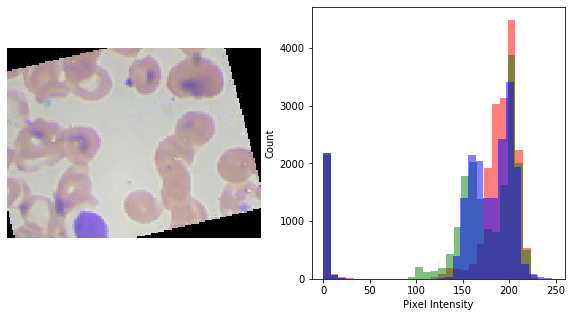

In [7]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

*Step Six: Preprocess Data*

In [8]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

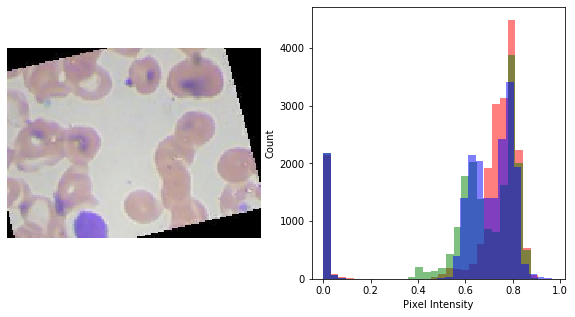

In [9]:
plotHistogram(X_train[1])

*Step Seven: Define Helper Functions*

In [10]:
# Helper Functions  Learning Curves and Confusion Matrix

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle = True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

*Step Eight: Evaluate Classification Models*

Num GPUs Available:  1
Built with CUDA:  True
  ...
    to  
  ['...']
Train for 312 steps, validate on 2487 samples
Epoch 1/35
311/312 [============================>.] - ETA: 0s - loss: 1.4604 - accuracy: 0.2563
Epoch 00001: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 30s 96ms/step - loss: 1.4599 - accuracy: 0.2564 - val_loss: 1.3991 - val_accuracy: 0.2505
Epoch 2/35
311/312 [============================>.] - ETA: 0s - loss: 1.3822 - accuracy: 0.2928
Epoch 00002: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 29s 92ms/step - loss: 1.3819 - accuracy: 0.2930 - val_loss: 1.2874 - val_accuracy: 0.4415
Epoch 3/35
311/312 [============================>.] - ETA: 0s - loss: 1.3066 - accuracy: 0.3797
Epoch 00003: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 29s 92ms/step - loss: 1.3067 - accuracy: 0.3794 - val_loss: 1.2216 - val_accuracy: 0.4194
Epoch 4

Epoch 29/35
311/312 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8359
Epoch 00029: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 28s 90ms/step - loss: 0.3897 - accuracy: 0.8357 - val_loss: 0.5115 - val_accuracy: 0.8203
Epoch 30/35
311/312 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8389
Epoch 00030: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 28s 91ms/step - loss: 0.3837 - accuracy: 0.8392 - val_loss: 0.6947 - val_accuracy: 0.7857
Epoch 31/35
311/312 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8473
Epoch 00031: saving model to training/classify/checkpoint.ckpt
312/312 [==============================] - 28s 90ms/step - loss: 0.3870 - accuracy: 0.8476 - val_loss: 0.4854 - val_accuracy: 0.8508
Epoch 32/35
311/312 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.8530
Epoch 00032: saving mode

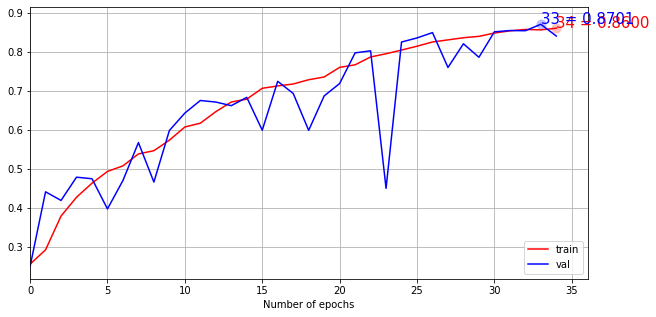

In [15]:
import math
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

checkpoint_path = "training/classify/checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

def runKeras(a,b,c,d,e):
    batch_size = 32
    num_classes = len(b[0])
    epochs = 35
    img_rows,img_cols=120,160
    input_shape = (img_rows, img_cols, 3)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy, optimizer=RMSprop(), metrics=['accuracy'])
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    history = model.fit(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=math.ceil(len(a) / batch_size), epochs=epochs, 
                        validation_data = [c, d],callbacks = [MetricsCheckpoint('logs'), cp_callback])
    
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), 
                                                      target_names=list(map_characters.values())), sep='') 
    model.save('training/final_type_model.h5') 
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotLearningCurve()
    plt.show()
    
runKeras(X_train,y_trainHot,X_test,y_testHot,1)